C:\Users\Tony\AppData\Local\Temp/ipykernel_12040/1360253515.py:181: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


done


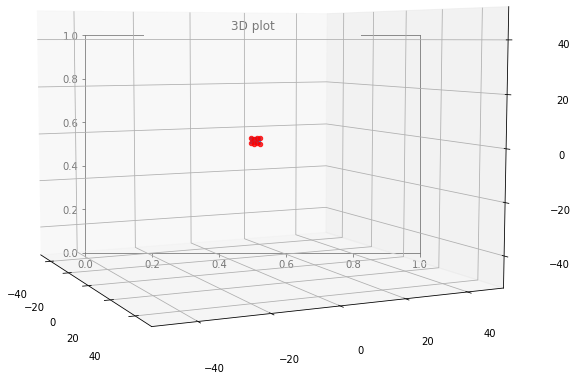

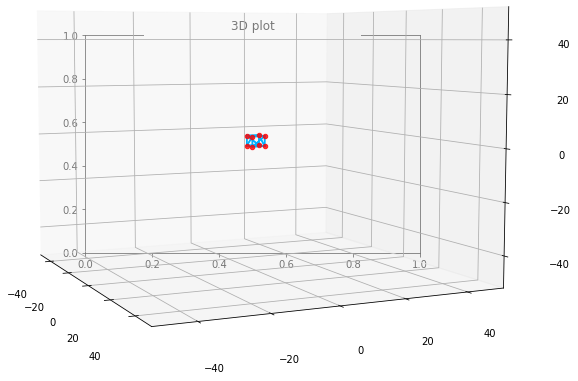

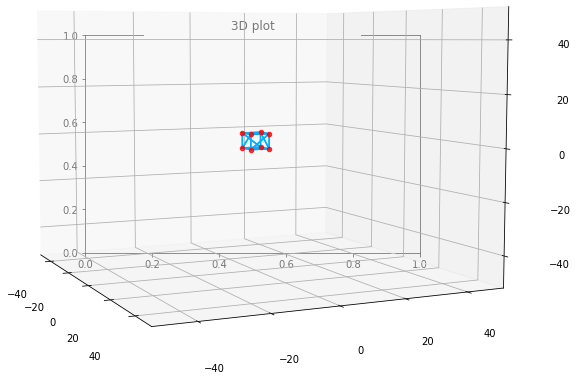

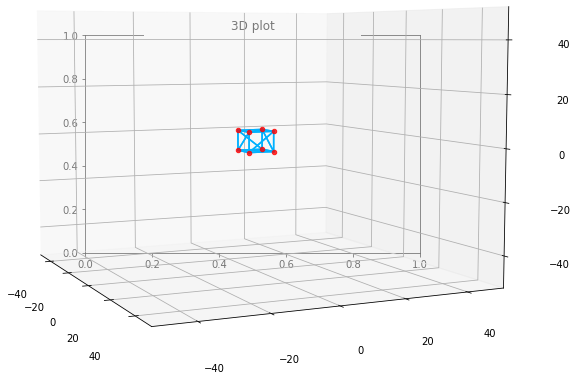

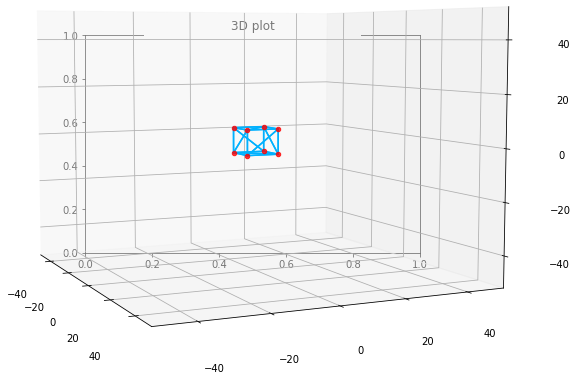

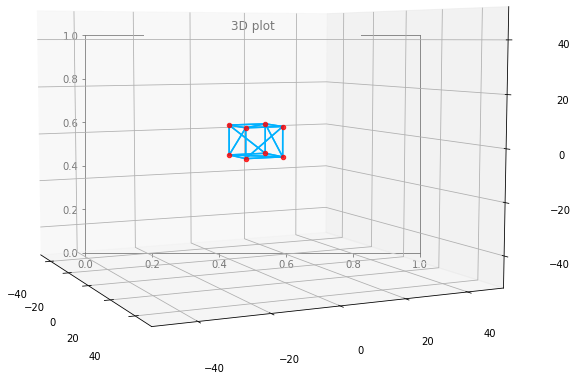

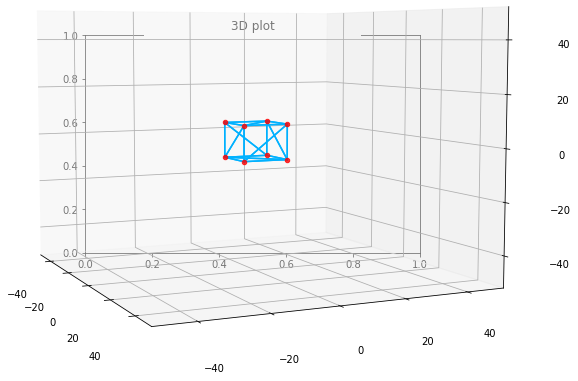

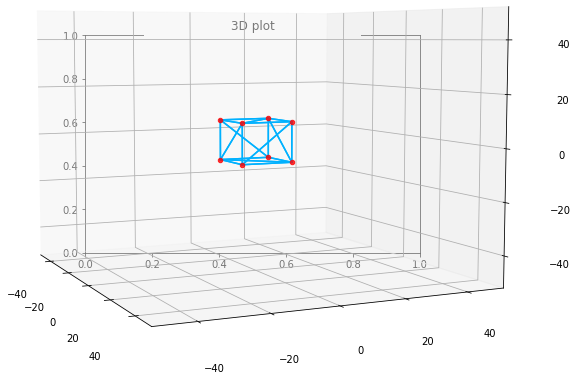

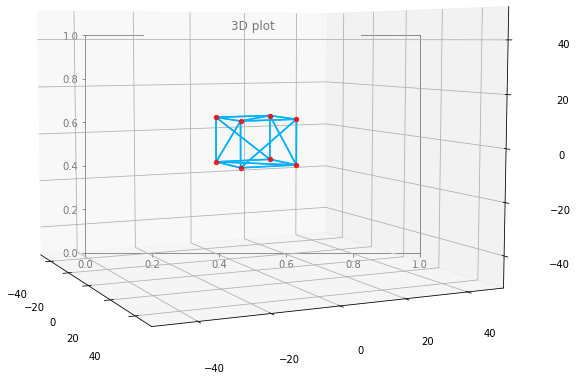

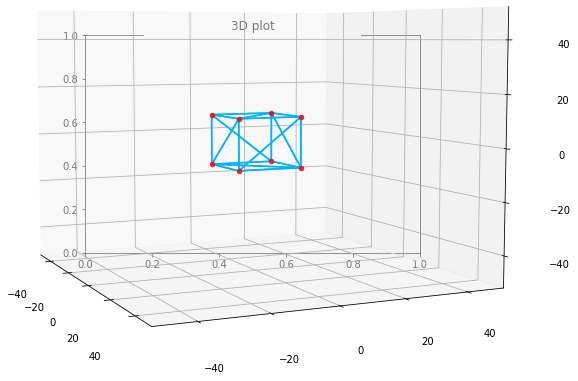

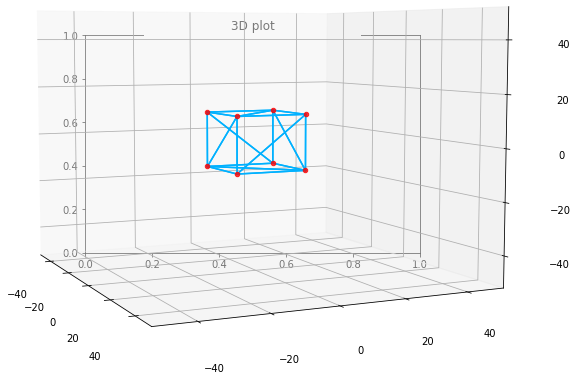

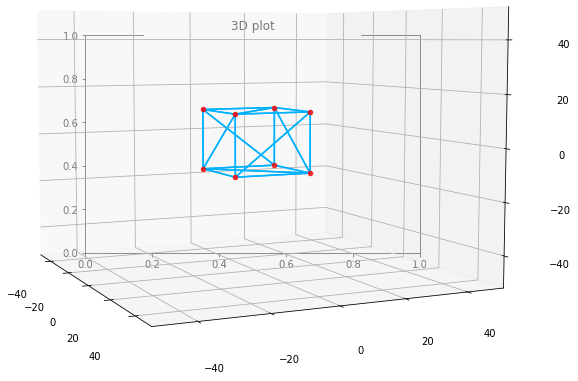

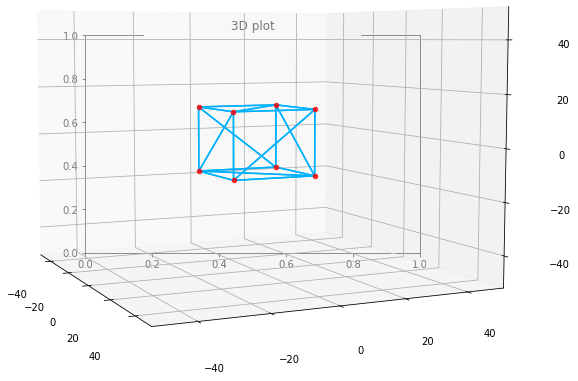

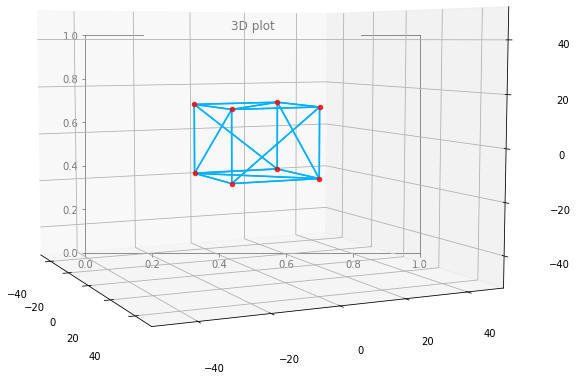

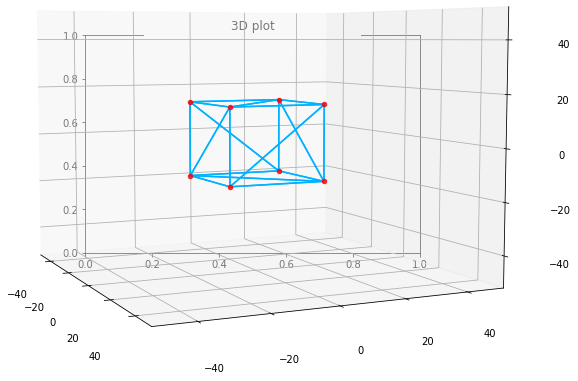

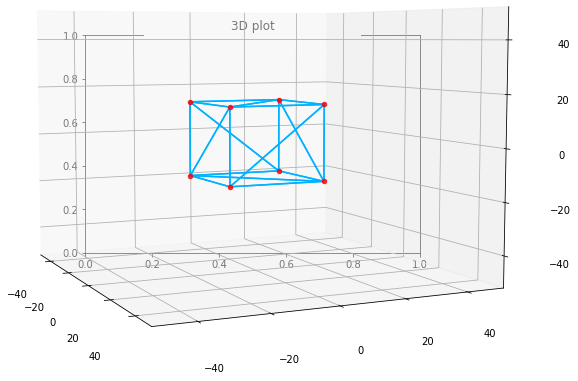

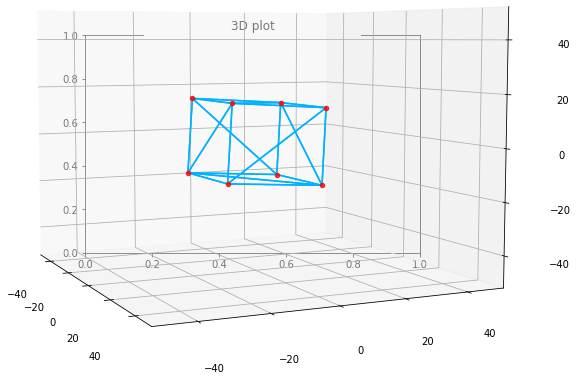

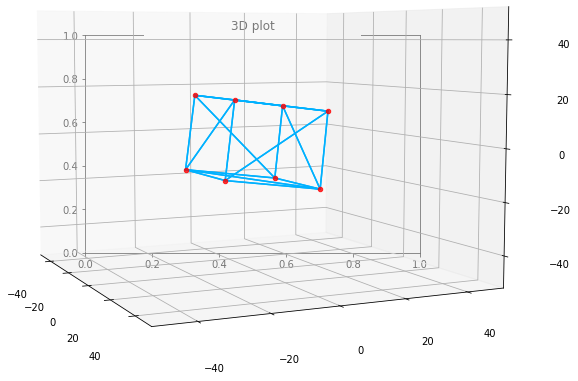

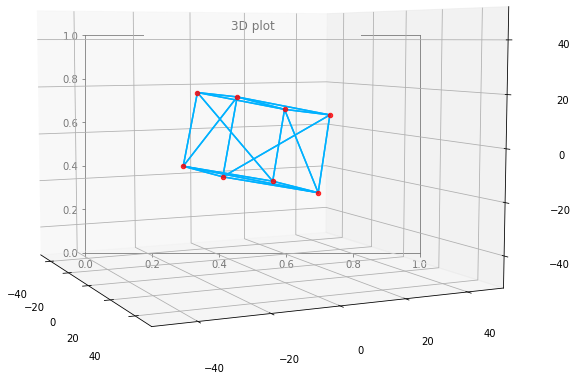

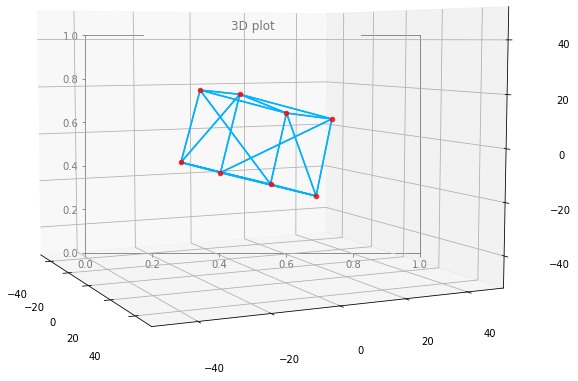

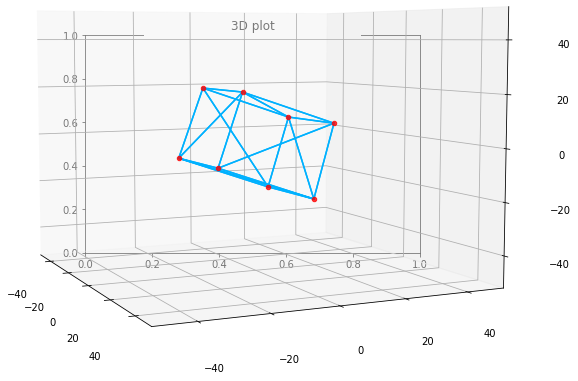

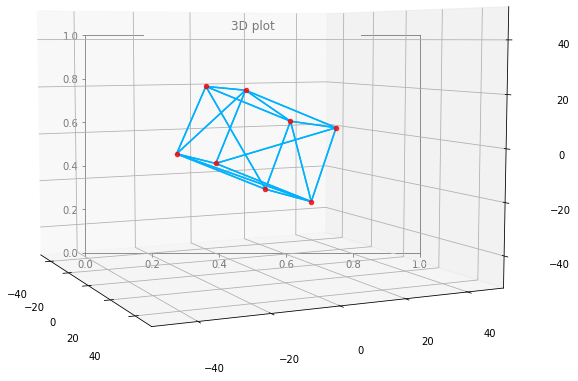

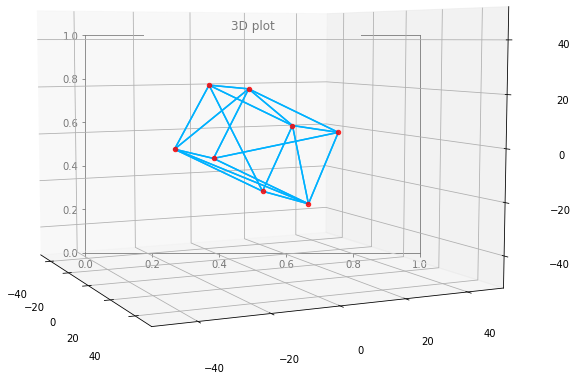

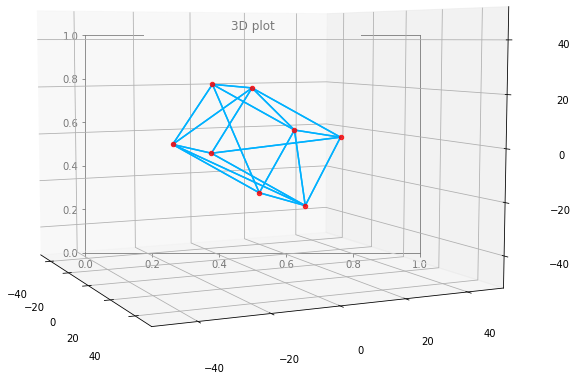

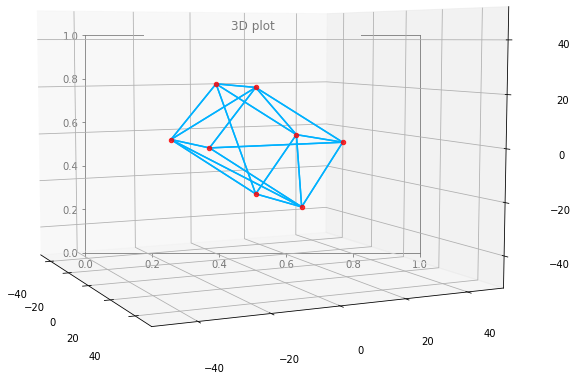

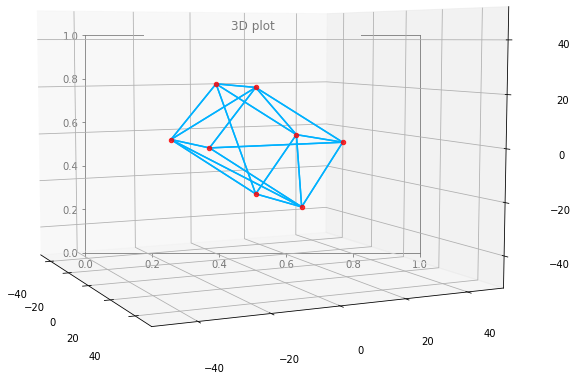

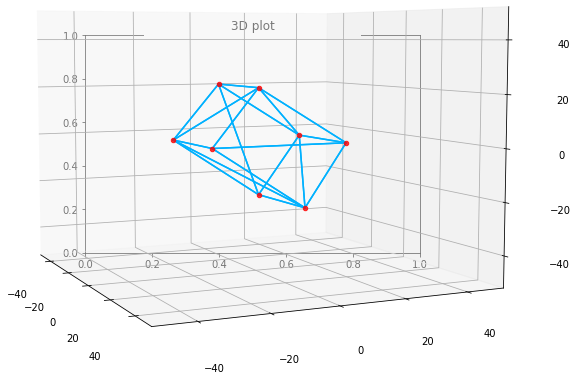

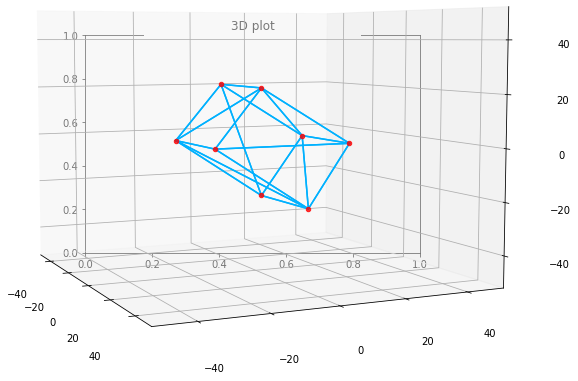

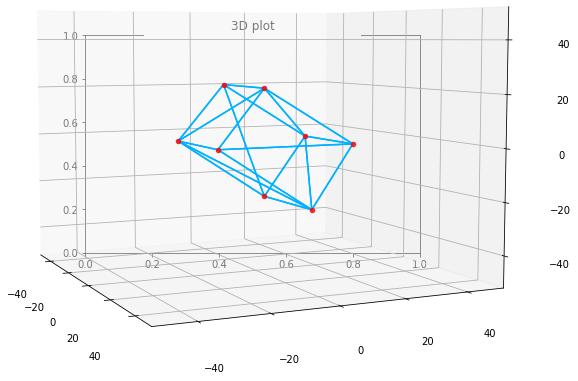

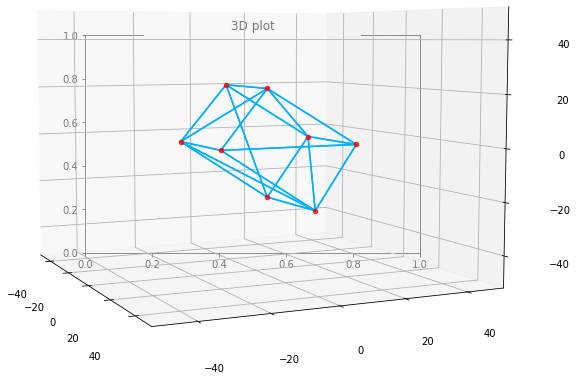

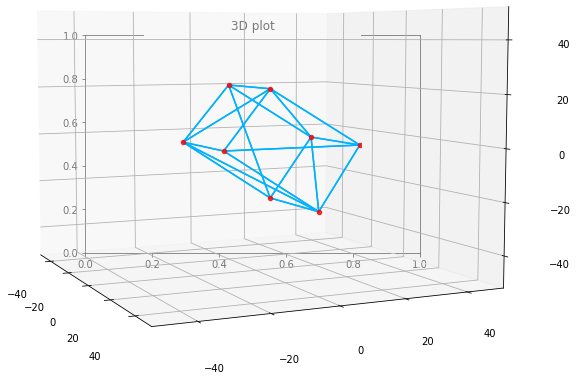

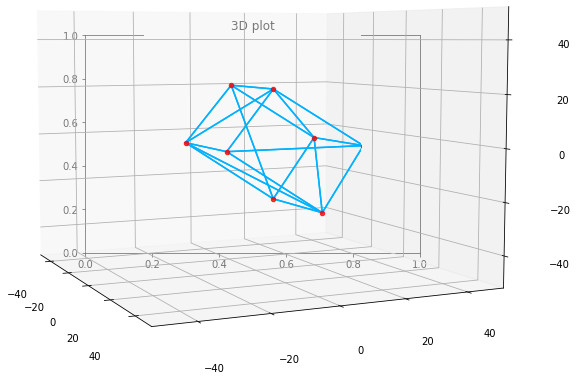

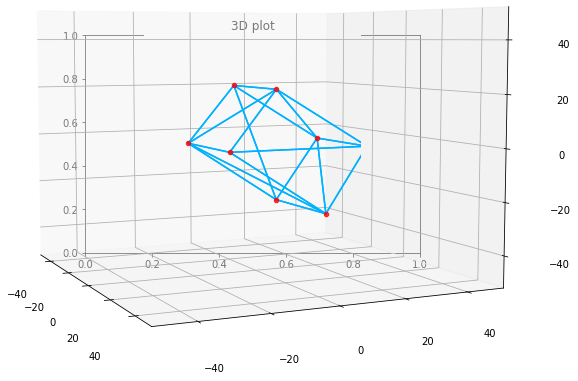

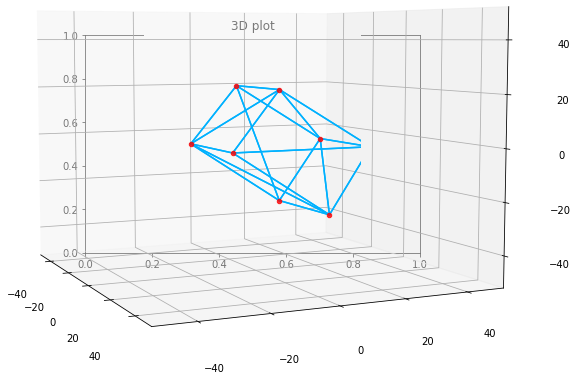

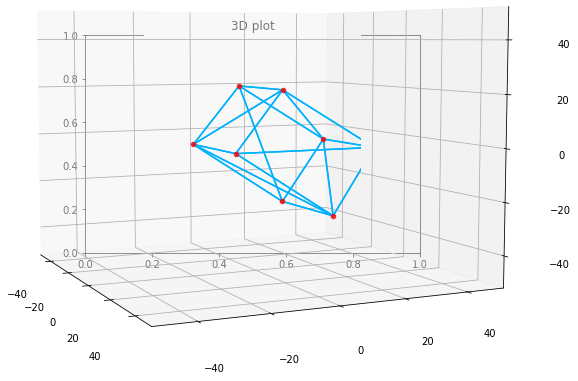

In [17]:

import math
from operator import matmul
from re import L
import plotly.graph_objects as go
from plyfile import PlyData, PlyElement
import matplotlib.pyplot as plt
#%matplotlib notebook
import numpy as np

def get_x_y_z_vertics(v):
    x_list = []
    y_list = []
    z_list = []
    for coord in v:
        x_list.append(coord[0])
        y_list.append(coord[1])
        z_list.append(coord[2])
    return x_list, y_list, z_list

#Change to only have triangular coordinations
#If polygon points are ginven more than 3 coordinations(traingular),
# change that coordination to triangular coordination
def make_triangular_face_coord(faces):
    triangular_face = []
    for face in faces:
        main_point = 0
        if (len(face) > 3):
            index = 1 #Fixed point
            while(index <= len(face) - 2):
                new_list = [face[main_point], face[index], face[index + 1]]
                index += 1
                triangular_face.append(np.array(new_list))
        else:
            triangular_face.append(face)
    return triangular_face

def get_face_indicies(faces):
    i_face = []
    j_face = []
    k_face = [] 
    for face in faces:
        i_face.append(face[0])
        j_face.append(face[1])
        k_face.append(face[2])
    return i_face, j_face, k_face

def conntect_edges(verticies, faces, ax):
    colors = plt.cm.jet([0.3, 0.7])
    # 0 1, 1, 2, 2, 3
    #Draw triangle lines
    for face in faces:
        index = 0
        while(True):
            if (index == 2):
                x1 = verticies[face[index]][0]
                y1 = verticies[face[index]][1]
                z1 = verticies[face[index]][2]

                x2 = verticies[face[0]][0]
                y2 = verticies[face[0]][1]
                z2 = verticies[face[0]][2]
                ax.plot([x1, x2],[y1, y2],[z1, z2], '-', c=colors[0])
                break
            else:
                x1 = verticies[face[index]][0]
                y1 = verticies[face[index]][1]
                z1 = verticies[face[index]][2]

                x2 = verticies[face[index + 1]][0]
                y2 = verticies[face[index + 1]][1]
                z2 = verticies[face[index + 1]][2]
                ax.plot([x1, x2],[y1, y2],[z1, z2], '-', c=colors[0])
                index += 1
    return ax
    
#Pad with 1
def extend_3d_to_4d(points : np.array):
    return np.append(points, 1)

#Truncate last index
def shrink_4d_to_3d(points):
    return np.delete(points, -1)

def shrink_3d_to_2d(points):
    # 3 X 2 identity
    matrix_reduction_factor = [[1, 0],
                               [0, 1],
                               [0, 0]] 
    return np.dot(points, matrix_reduction_factor)

#Transformation on biased side  - may need in form of 4d
def affine_traslation_transform(points, t1, t2, t3):
    t_matrix = np.transpose([t1, t2, t3])
    return np.add(points, t_matrix)

#Transformation on uniform side
def affine_uniform_scale_3d(matrix, resize_factor):
    resize_matrix_factor = np.identity(3) * resize_factor
    return np.dot(resize_matrix_factor, matrix.tolist())

#Rotation - x, y, z
def rotate_3d(matrix, yaw_degree, pitch_degree, roll_degree):
    yaw_degree = math.radians(yaw_degree)
    pitch_degree = math.radians(pitch_degree)
    roll_degree = math.radians(roll_degree)

    yaw_matrix = np.array([[1, 0, 0, 0],
                           [0, math.cos(yaw_degree), -math.sin(yaw_degree), 0],
                           [0, math.sin(yaw_degree), math.cos(yaw_degree), 0],
                           [0, 0, 0, 1]])

    pitch_matrix = np.array([[math.cos(pitch_degree), 0, math.sin(pitch_degree), 0],
                             [0, 1, 0, 0],
                             [-math.sin(yaw_degree), 0, math.cos(pitch_degree), 0],
                             [0, 0, 0, 1]])

    roll_matrix = np.array([[math.cos(roll_degree), -math.sin(roll_degree), 0, 0],
                            [math.sin(roll_degree), math.cos(roll_degree), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
    rotational_factor_matrix = np.matmul(np.matmul(yaw_matrix,
                                                   pitch_matrix),
                                                   roll_matrix)
    return np.matmul(matrix.tolist(), rotational_factor_matrix)

#Inverse
def inverse_3d(matrix):
    return np.linalg.inv(matrix)

#Reflection
def reflection_3d():
    pass

#Shear
def shear_in_x_axis (points, shear_y, shear_z):
    new_points = np.add(np.ones((1, 4)), points)
    shear_x_value = [[1, 0, 0, 0],
                     [shear_y, 1, 0, 0],
                     [shear_z, 0, 1, 0],
                     [0, 0, 0, 1]]
    return np.matmul(shear_x_value, new_points)

def shear_y_axis (points, shear_y, shear_z):
    new_points = np.add(np.ones((1, 4)), points)
    shear_y_value = [[1, 0, 0, 0],
                     [shear_y, 1, 0, 0],
                     [shear_z, 0, 1, 0],
                     [0, 0, 0, 1]]
    return np.matmul(shear_y_value, new_points)

def shear_z_axis (points, shear_x, shear_y):
    new_points = np.add(np.ones((1, 4)), points)
    shear_z_value = [[1, 0, shear_x, 0],
                     [0, 1, shear_y, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]]
    return np.matmul(shear_z_value, new_points)

def draw_vertices(x, y, z, ax):
    #Color map
    my_cmap = plt.get_cmap('hsv')
    ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap)
    return ax

def single_frame(verticies, ax, faces):
    #Get verticies
    x_verticies, y_verticies, z_verticies = get_x_y_z_vertics(verticies)

    #Draw vertices
    for i in range(len(x_verticies)):
        ax = draw_vertices(x_verticies[i], y_verticies[i], z_verticies[i], ax)

    #Connect lines
    ax = conntect_edges(verticies, faces, ax)

#Creates graphical frameworks
def reset_figure():
    plt.figure()
    plt.title("3D plot")
    #Set fixed view point
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(-50, 50)
    ax.set_ylim3d(-50, 50)
    ax.set_zlim3d(-50, 50)
    ax.azim = -25 #The azimuth is the rotation around the z axis
    ax.dist = 4 #Distance from the center visible point
    ax.elev = 5 #Angle between the eye and the xy plane
    return ax

#Given data from ply file
plydata = PlyData.read('./data/cube.ply')
verticies = np.array(plydata.elements[0].data)
faces = plydata['face'].data['vertex_indices']
faces = make_triangular_face_coord(faces)

#Percolate data to usable data
x_verticies, y_verticies, z_verticies = get_x_y_z_vertics(verticies)
#x_indices, y_indices, z_indices = get_face_indicies(faces)

uniformed_verticies = []
#Gradual uniform resize
for i in range(15):
    ax = reset_figure()
    uniformed_verticies = []
    for vertex in verticies:
        uniformed_verticies.append(affine_uniform_scale_3d(vertex, i + 1))
    single_frame(uniformed_verticies, ax, faces)
    plt.savefig("1_" + str(i) + ".png")

rotated_verticies = []
#Gradual rotation
for i in range(10):
    ax = reset_figure()
    rotated_verticies = []
    for vertex in uniformed_verticies:
        extendted_vertex = extend_3d_to_4d(vertex)
        result_4d_vertices = rotate_3d(extendted_vertex, 5 * i, 0, 0)
        result_3d_vertices = shrink_4d_to_3d(result_4d_vertices)
        rotated_verticies.append(result_3d_vertices)
    single_frame(rotated_verticies, ax, faces)
    plt.savefig("2_" + str(i) + ".png")

#Transformation
for i in range(10):
    ax = reset_figure()
    transformed_vertices = []
    for vertex in rotated_verticies:
        tranformed_vertex = affine_traslation_transform(vertex, i * 2, 0, 0)
        transformed_vertices.append(tranformed_vertex)
    single_frame(transformed_vertices, ax, faces)
    plt.savefig("3_" + str(i) + ".png")

print("done")